Import libraries

In [161]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

Fetch Data

In [162]:
# Ticker symbol of the underlying asset
ticker_symbol = "AAPL"

# Expiration date for the options (YYYY-MM-DD format)
expiration_date = "2023-12-15"

# Create a Ticker object
ticker = yf.Ticker(ticker_symbol)

# Get option chain for the specified expiration date
option_chain = ticker.option_chain(expiration_date)

# Access call option data
calls = option_chain.calls

# Extract available strike prices and option prices
available_strike_prices = calls['strike'].values
available_option_prices = calls['lastPrice'].values

# Get current stock price from the Ticker object
S = ticker.history(period="1d")['Close'][0]



Define other parameters

In [163]:
# Other parameters
T = 0.5      # Time to expiration (in years)
r = 0.03     # Risk-free rate
sigma = 0.25 # Volatility
num_simulations = 10000  # Number of simulations for Monte Carlo


Black-Scholes Method

In [164]:
def black_scholes(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

CRR Method

In [165]:
def crr_option_pricing(S, K, T, r, sigma, num_steps):
    dt = T / num_steps
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    option_prices = []
    for j in range(num_steps + 1):
        option_prices.append(max(0, S * (u ** (num_steps - j)) * (d ** j) - K))

    for i in range(num_steps - 1, -1, -1):
        for j in range(i + 1):
            option_prices[j] = np.exp(-r * dt) * (p * option_prices[j] + (1 - p) * option_prices[j + 1])

    return option_prices[0]


JD Method

In [166]:
def jr_option_pricing(S, K, T, r, sigma, num_steps):
    dt = T / num_steps
    u = np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt))
    d = np.exp((r - 0.5 * sigma**2) * dt - sigma * np.sqrt(dt))
    p = 0.5

    option_prices = []
    for j in range(num_steps + 1):
        option_prices.append(max(0, S * (u ** (num_steps - j)) * (d ** j) - K))

    for i in range(num_steps - 1, -1, -1):
        for j in range(i + 1):
            option_prices[j] = np.exp(-r * dt) * (p * option_prices[j] + (1 - p) * option_prices[j + 1])

    return option_prices[0]


Monte Carlo Simulation

In [167]:
def monte_carlo_option_pricing(S, K, T, r, sigma, num_simulations):
    z = np.random.randn(num_simulations)
    terminal_prices = S * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * z)
    option_payoffs = np.maximum(terminal_prices - K, 0)
    option_price = np.exp(-r * T) * np.mean(option_payoffs)
    return option_price

 Calculate option prices using different methods

In [168]:
bs_model_prices = [black_scholes(S, K, T, r, sigma) for K in available_strike_prices]
crr_model_prices = [crr_option_pricing(S, K, T, r, sigma, num_steps=100) for K in available_strike_prices]
jr_model_prices = [jr_option_pricing(S, K, T, r, sigma, num_steps=100) for K in available_strike_prices]
mc_model_prices = [monte_carlo_option_pricing(S, K, T, r, sigma, num_simulations) for K in available_strike_prices]

Plot option data

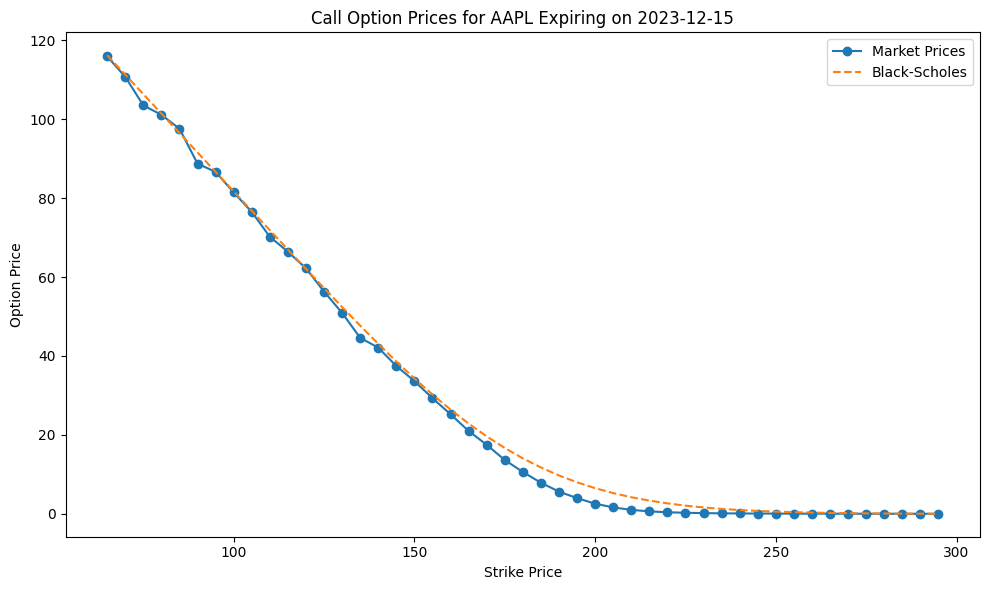

In [169]:
plt.figure(figsize=(10, 6))
plt.plot(available_strike_prices, available_option_prices, label="Market Prices", marker='o')
plt.plot(available_strike_prices, bs_model_prices, label="Black-Scholes", linestyle='--')

plt.title(f"Call Option Prices for {ticker_symbol} Expiring on {expiration_date}")
plt.xlabel("Strike Price")
plt.ylabel("Option Price")
plt.legend()
plt.tight_layout()
plt.show()

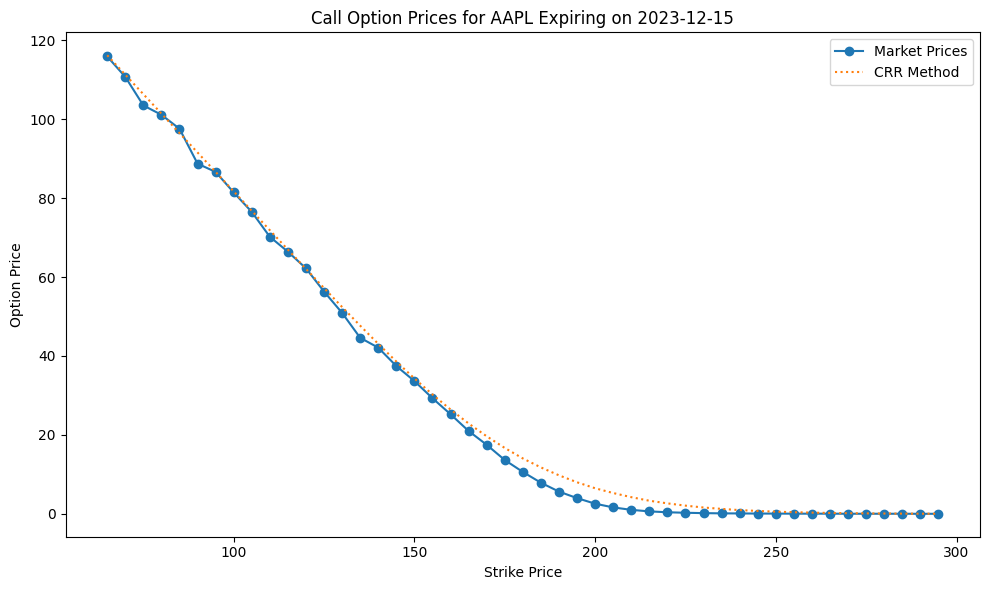

In [170]:
plt.figure(figsize=(10, 6))
plt.plot(available_strike_prices, available_option_prices, label="Market Prices", marker='o')
plt.plot(available_strike_prices, crr_model_prices, label="CRR Method", linestyle=':')

plt.title(f"Call Option Prices for {ticker_symbol} Expiring on {expiration_date}")
plt.xlabel("Strike Price")
plt.ylabel("Option Price")
plt.legend()
plt.tight_layout()
plt.show()

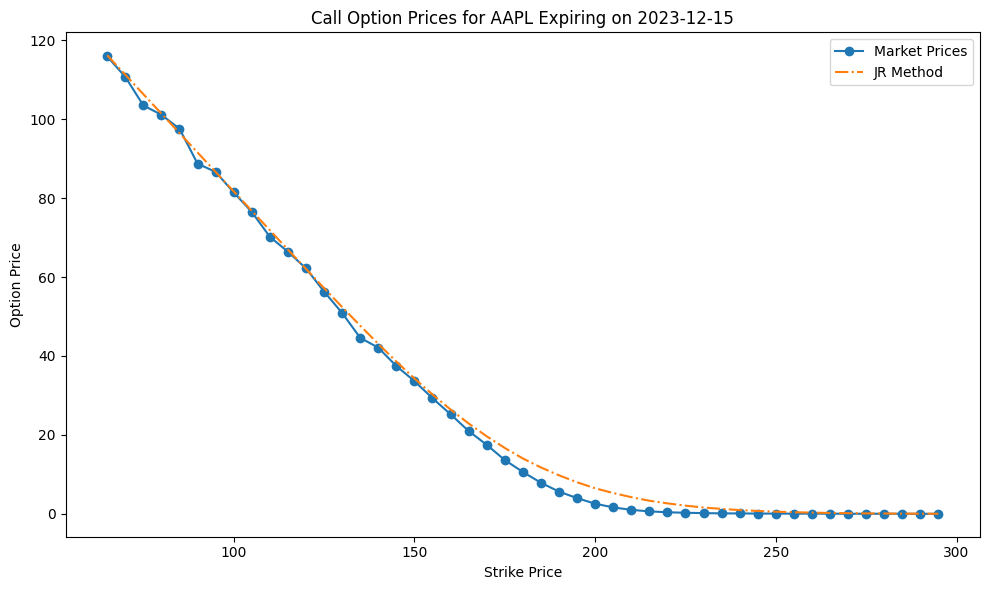

In [171]:
plt.figure(figsize=(10, 6))
plt.plot(available_strike_prices, available_option_prices, label="Market Prices", marker='o')
plt.plot(available_strike_prices, jr_model_prices, label="JR Method", linestyle='-.')

plt.title(f"Call Option Prices for {ticker_symbol} Expiring on {expiration_date}")
plt.xlabel("Strike Price")
plt.ylabel("Option Price")
plt.legend()
plt.tight_layout()
plt.show()

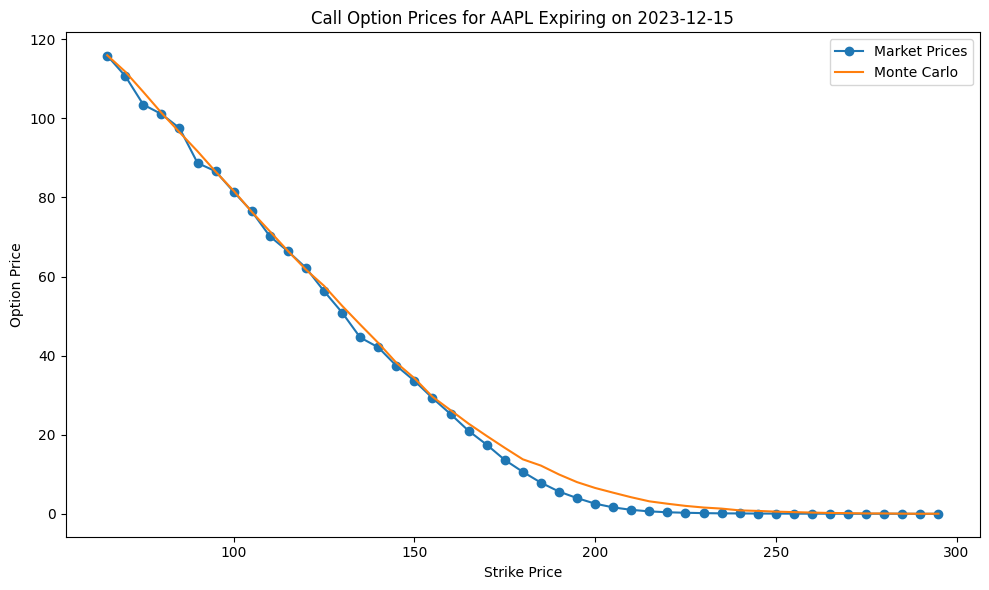

In [172]:
plt.figure(figsize=(10, 6))
plt.plot(available_strike_prices, available_option_prices, label="Market Prices", marker='o')
plt.plot(available_strike_prices, mc_model_prices, label="Monte Carlo", linestyle='-')

plt.title(f"Call Option Prices for {ticker_symbol} Expiring on {expiration_date}")
plt.xlabel("Strike Price")
plt.ylabel("Option Price")
plt.legend()
plt.tight_layout()
plt.show()